# Red neuronal CNN
## Descripción del problema a resolver
Tener la capacidad de categorizar el rostro de las personas a un sentimiento en específco, basandonos únicamente en la expresión del rostro de la persona.

### Porqué la elección del dataset
Me parecio interesante poder hacer validacion de expresiones faciales, a pesar de ser un dataset limitado a solo ciertos sentimientos y una baja resolución, creo que es algo que puede llegarse a aplicar de buena forma en servicio al cliente. Se acabarian las encuestas, con la expresión facial se podria hacer muchas conclusiones.

Primero hacemos import de las librerias necesarias

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Identificación de desbalanceos o problemas

Al verificar el dataset, podemos observar que en efecto la gran mayoria de elementos tiene una resolución de 48 x 48, lo cual lo hace una resolución bastante reducida para la cantidad de pixel de las imágenes actuales. Pero, a pesar de ello, se tiene algunos ejemplos de imágenes un poco mayores (en una considerable menor cantidad) pero permiten a que el modelo pueda entrenarse a esa resolución, ayudando un poco a que sus predicciones sean mejores.

Por otro lado hay imágenes las cuales no tienen mayor información o almenos no es posible verlas, las cuales podrian generar un cierto ruido en nuestro modelo.

## Preprocesamiento
### Limpieza de datos
Para la limpieza de datos se busca remover las imágenes que no suman e inclusive podrian afectar a nuestro modelo y sus predicciones futuras, por lo que se removeran dichas imágenes. En la inspección de los datos, se pudo apreciar que el tamaño donde las imágenes fallan es cuando son menores a 1 Kb.

Cabe mencionar que se hizo una exploracion manual de las mismas y se eliminaron algunas no viables que estaban a la cercania de este tamaño.

In [6]:

def remove_small_images(directory, min_size_kb=1):
    removed = 0
    min_bytes = min_size_kb * 1024
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                if os.path.getsize(file_path) < min_bytes:
                    os.remove(file_path)
                    removed += 1
                    print(f"Removed: {file_path}")
            except Exception as e:
                print(f"Error removing {file_path}: {e}")
    print(f"\nTotal files removed from {directory}: {removed}")

remove_small_images("datasets/Angry", min_size_kb=1)
remove_small_images("datasets/Fear", min_size_kb=1)
remove_small_images("datasets/Happy", min_size_kb=1)
remove_small_images("datasets/Sad", min_size_kb=1)
remove_small_images("datasets/Happy", min_size_kb=1)

Removed: datasets/Angry/11001465.png
Removed: datasets/Angry/11286.png
Removed: datasets/Angry/12352.png
Removed: datasets/Angry/13148.png
Removed: datasets/Angry/13402.png
Removed: datasets/Angry/15878818.png
Removed: datasets/Angry/15894.png
Removed: datasets/Angry/16195868.png
Removed: datasets/Angry/19885833.png
Removed: datasets/Angry/20222.png
Removed: datasets/Angry/20817.png
Removed: datasets/Angry/22198.png
Removed: datasets/Angry/2387286.png
Removed: datasets/Angry/24441.png
Removed: datasets/Angry/26065204.png
Removed: datasets/Angry/26860.png
Removed: datasets/Angry/28601.png
Removed: datasets/Angry/30002.png
Removed: datasets/Angry/32662.png
Removed: datasets/Angry/34790.png
Removed: datasets/Angry/5439.png
Removed: datasets/Angry/6458.png
Removed: datasets/Angry/65799569.png
Removed: datasets/Angry/66143550.png
Removed: datasets/Angry/74507150.png
Removed: datasets/Angry/7496.png
Removed: datasets/Angry/75698697.png
Removed: datasets/Angry/94894933.png
Removed: datasets/A

## Exploración de datos (EDA)
### Carga del dataset y visualización de los datos

Ahora hacemos la importación de la data que esta en la carpeta de datasets y por medio de la funcion de keras de image_dataset_from_directory() cargamos en memoria las imágenes. Luego hacemos la impresion de las mismas

El tamaño de las imágenes se pone a 128 x 128 dado a que el tamaño de las imágenes medio es cercano ese valor (48 x 48), por lo que con ese tamaño tomamos en cuenta la mayoria de escenarios de nuestro dataset y aun nos da posibilidad de obtener información de las imágenes que tengan un mayor tamaño.

Otro parametro interesante es el label_mode dado a que el dataset esta en carpetas de las categorias, por lo que permite establecer las entradas de las imágenes a cierta categoria.

El batch_size consiste en cuantas imágenes estaremos agregando en memoria a la vez, y es el mismo que estara utilzando para la función de entrenamiento.

Tambien con image_dataset_from_directory() permite definir de una sola vez la x y la y, poque devuelve ambos valores.

In [9]:
DATASET_DIR = 'datasets'
IMG_WIDTH=128
IMG_HEIGHT=128
SEED=281
VALIDATION_SPLIT=0.2
BATCH_SIZE=64

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


Found 58994 files belonging to 5 classes.
Using 47196 files for training.
Found 58994 files belonging to 5 classes.
Using 11798 files for validation.


### Visualización de datos
Ahora visulizamos las distintas imágenes disponibles, para darnos una idea de con que tipo de data estamos trabajando.

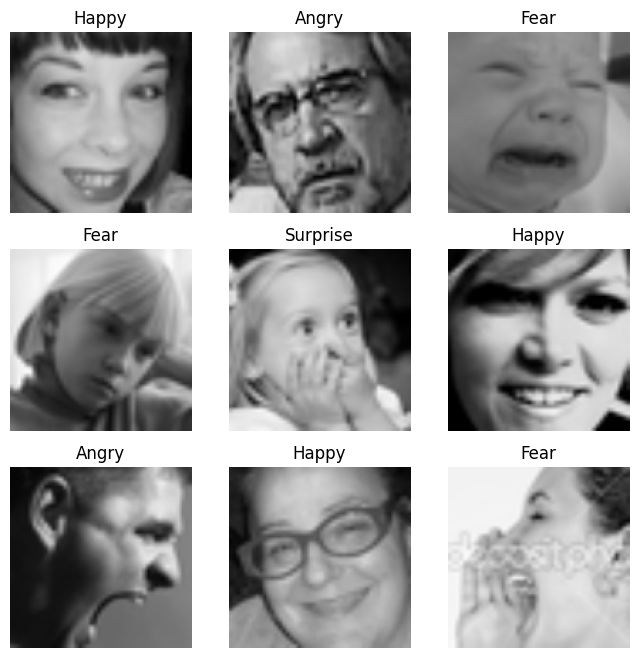

In [ ]:
def get_category_name(index):
    res = ""
    if index == 0:
        res = "Angry"
    elif index == 1:
        res = "Fear"
    elif index == 2:
        res = "Happy"
    elif index == 3:
        res = "Sad"
    elif index == 4:
        res = "Surprise"
    return res

for images, labels in train_ds.take(1):
    # Plot the first 9 images
    plt.figure(figsize=(8, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(get_category_name(tf.argmax(labels[i]).numpy()))
        plt.axis("off")

### Estadística descriptiva
Hacemos una verificación gráfica de la información en nuestro dataset. Dado a que el objectivo es detectar rostros que tengan ciertas características para clasificarla en sentimientos, creo que es interesante la cantidad que tenemos de cada una, con lo cual obtenemos los siguientes resultados.

In [5]:
print("Conteo de imagenes por tipo")
class_names = train_ds.class_names
image_counts = defaultdict(int)
total = 0
for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_dir):
        count = len(os.listdir(class_dir))
        image_counts[class_name] = count
        print(f"{class_name}: {count} imágenes")
        total += count

print("Total de imágenes:", total)

Conteo de imagenes por tipo
Angry: 10148 imágenes
Fear: 9732 imágenes
Happy: 18439 imágenes
Sad: 12552 imágenes
Suprise: 8207 imágenes
Total de imágenes: 59078


## Definición de modelo y normalización de imágenes
Ahora, podemos definir el modelo, el cual se explica a continuación:

- La entrada es de las imagenes convertidas, con 3 filas que representan las capas de color
- Se aplica una capa de rescalamiento, para la normalización de las imágenes, siendo los 255, los valores de los pixeles en cada capa de color.
- Luego se tienen capas de convolución 2D con funcion relu de activación de 32 a 128 neuronas para ir tomando los elementos de la imagen de los mas pequeños a los mas grandes
- Luegos estan las capas de MaxPooling para hacer las operaciones convulocionales y se establecen de 2x2
- Luego hay una capa de droput para evitar el overfittig
- Luego una capar Flattern, para vectorizar las salidas de las imágenes
- Por úlitmo una capa de salida softmax que permite darnos una salida con las probabilidades de cada una de la clasificación de la imagen a verificar

In [17]:
model = keras.Sequential([
    layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

## Entrenamiento
Ahora procedemos a entrenar el modelo. Los parámetros utilzados son:
- Funcion de optimización: Adam
- Función de loss: categorical_crossentropy, dado a que la salida del modelo se espera una salida de categorias
- Learning rate: 0.001
- Epochs: 30
- Batch size: 64
- Validation split: 0.15

Ahora se procede con el proceso de entranamiento, y se define con una función callback que permite cancelar el proceso si se nota que no existe un ajuste en 5 epoch seguidas

Se habia agregado una función de checkpoint para poder ir guarando en cada epoch, pero lamentablemente no logró funcionar y fue removida por ese motivo.

Pero se guarda el modelo luego del entrenamiento y esta el archivo disponible para que pueda cargarse cuando se desee.

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

model.save('cnn_model.keras')

Epoch 1/30


KeyboardInterrupt: 

Para no tener que hacer el entrenamiento nuevamente.

In [24]:
model = keras.models.load_model('cnn_model.keras')

## Evaluación y resultados
### Métricas en conjunto de test
Ahora procesdemos a graficar y verificar la información obtenida. Los resultados finales fueron:
- Acuaracy: 84.28%
- Loss: 34.80

In [25]:
model.evaluate(val_ds)

185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9723 - loss: 0.1332


[0.13317473232746124, 0.9722834229469299]

### Visualizacion de curvas de aprendizaje

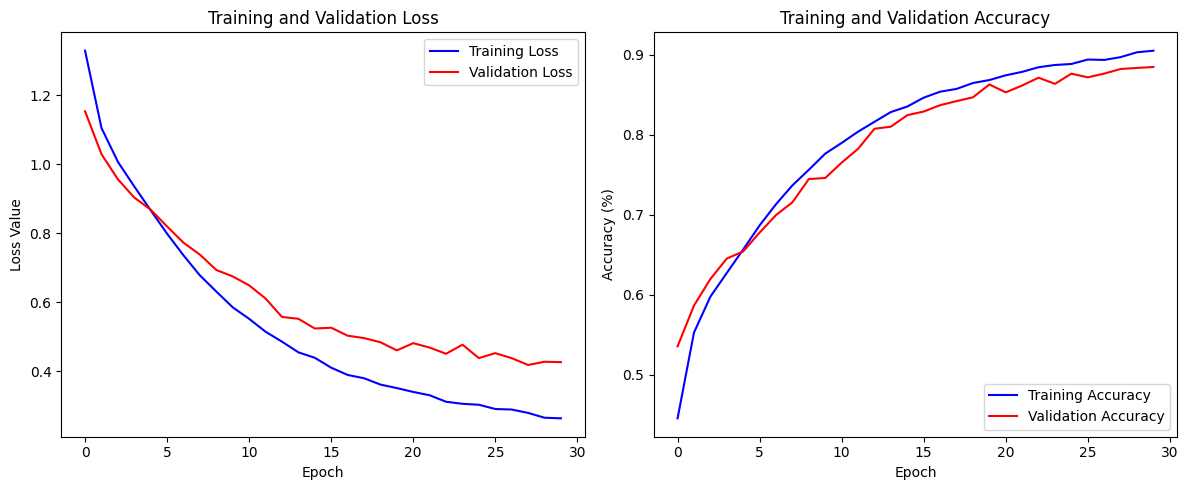

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 5))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1) # 1 row, 2 columns, plot 1
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, plot 2
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

### Matriz de confusión

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━

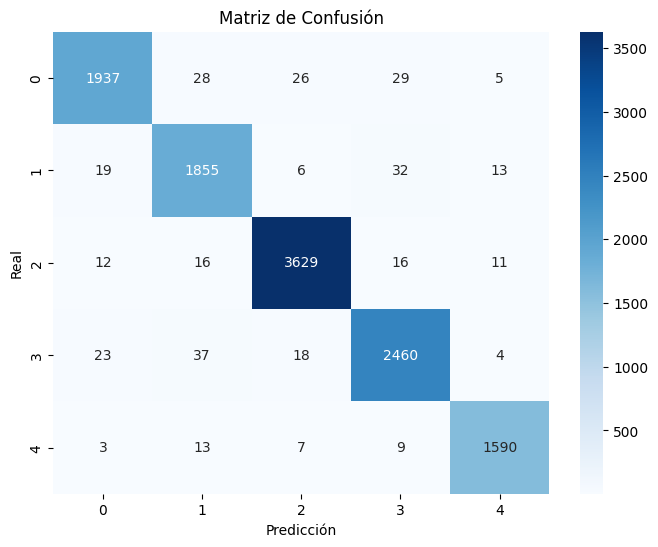

In [30]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

### Ejemplos de predicción
Ahora procedemos a hacer una prueba del modelo, con imagenes sacadas de internet de la carpeta test

In [31]:
test_dir = 'test'
imgs = sorted(os.listdir(test_dir))
for fn in imgs:
    fp = os.path.join(test_dir, fn)
    img = image.load_img(fp, target_size=(IMG_WIDTH, IMG_HEIGHT))
    arr = image.img_to_array(img)             
    arr = np.expand_dims(arr, 0)                       # batch dim
    probs = model.predict(arr, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    print(f"{fn} -> {class_names[pred_idx]} ({probs[pred_idx]:.3f})")

angry.png -> Angry (0.762)
fear.png -> Fear (0.956)
happy.png -> Happy (1.000)
sad.png -> Sad (0.612)
surprise.png -> Suprise (0.980)


## Análisis de resultados
### Intepretación de resultados
El modelo llegó a un nivel aceptable de accuaracy y de la función del loss, y visualizando la matriz de confusión podemos ver de que tiene resultados aceptables, la mayor parte de los datos está en la clase que debe de estar. También los resultados fueron positivos al momento de hacer las pruebas. Por lo que puede decirse que la red neuronal funciona bien.

Sin embargo, funciona bien para el escenario establecido, para poder utilizarlo en un escenario real o productivo, tiene muchas fallas especialmente por la data utilizada que no se compara con la resolución que se maneja en la actualidad.

### Limitación del modelo
Las limitaciones del modelo creo que consisten en que para que la predicción fuera correcta, se tuvo que extraer solo el rostro de las personas de las imágenes. Esto dificulta dado a que en escenarios reales la data no viene se necesita, sino que viene en muchas formas que el modelo deberia de ser capaz de interpretar, sin embargo no fue el caso.

Puedo entender que existe una variante de la CNN que podria llegar a manejar este escenario, la cual es MTCNN, que podria seguramente obtener mejores resultados.

### Posibles mejoras
Creo que uno de las mejoras que deberian de existir es que el dataset utilizado tiene un parecido muy leve con la data que actualmente se podria estar manejando. Las imagenes, en su mayoria, tienene una resolucion muy baja y muchas de ellas son en blanco y negro. Esto no permite que un modelo pueda llegar a tener buenos resultados en escenarios reales.

A pesar de que las pruebas realizadas fueron exitosas, con imágenes extraidas de internet, fueron elegida a prueba y error, y haciendo el recorte exacto en el rostro de la persona, esto muestra las limitantes del modelo y que con data mejorada, por ende se podrian convertir a un tamaño mayor para perder menos información, podrian realizarse mejores predicciones.

Otra cosa a tomar en cuenta es la capacidad de computo, que la mentablemente, a pesar de que mi pc tiene una tarjeta de video nvidia, no pudo funcionar correctamente, por lo que se tuvo que utilizar el CPU para entrenamiento.